<a href="https://colab.research.google.com/github/robgon-art/clip-design-patents/blob/main/Using_OpenAI's_CLIP_to_Search_for_Design_Patents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using OpenAI's CLIP to Search for Design Patents**

### Using natural language to search and find over sixty thousand industrial designs that have entered the public domain since 2002

This Colab is based on [Interacting with CLIP](https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb) by OpenAI and [Beyond Tags - Semantic Search on images with OpenAI CLIP ](https://) by Ramsri Goutham.

Hover over play button and hit the Run cell.

It takes about a minute to complete the setup.


In [ ]:
#@title
!gdown --id 1-0PqTuOMhpiNtFepmjGWU79mj3Tckk3w
!gdown --id 1-06qsyzgGV0HWnT6JVzgC3SVK2GSOiPT
!gdown --id 1--SezGS4Fjnj0t6WFEOBXPSmPQhmaZ_L
!gdown --id 1--0ThLCj8rxSFNODbY-RM2qZsv3Sd7UX
import numpy as np
import torch
text_features = torch.tensor(np.load('text_features.npy'))
image_features = torch.tensor(np.load('image_features.npy'))
import pickle
f = open("labels.pkl",'rb')
labels = pickle.load(f)
f.close()
!unzip -o design_patent_images.zip > /dev/null 2>&1
import glob
image_files = sorted(glob.glob("design_patent_images/*.png"))
!wget https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt -O model.pt
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()
!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
from functools import lru_cache
@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs
def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()
def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text
class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)
    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)
        if not pairs:
            return token+'</w>'
        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word
    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens
    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text
!pip install ipyplot
!pip install ftfy
combined_features = torch.hstack((text_features, image_features))
combined_features /= combined_features.norm(dim=-1, keepdim=True)
import gzip
import regex as re
import ftfy
from PIL import Image
tokenizer = SimpleTokenizer()
def get_text_features(sentence):
  text_tokens = [tokenizer.encode("%s "%(sentence) + "<|endoftext|>")]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)
  text_input = text_input.cuda()
  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  return text_features
def get_top_N_semantic_similarity(similarity_list, N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_N_images = []
  scores = []
  indices = []
  for index,score in results[:N]:
    scores.append(score)
    image = Image.open(image_files[index])
    top_N_images.append(image)
    # top_N_images.append(all_images[index])
    indices.append(index)
  return scores, top_N_images, indices
  import ipyplot
  import html

## Search Design Patents
Type in a query, choose the query type, set the number of reslults, and then hit the play button.


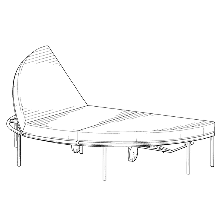
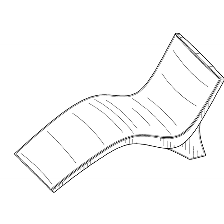
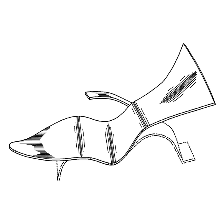
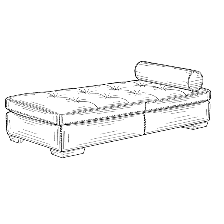
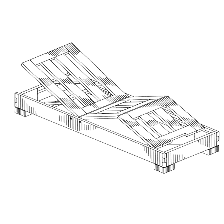
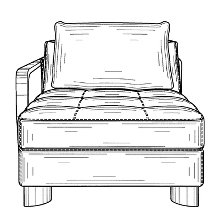
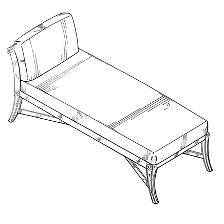


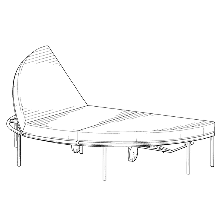
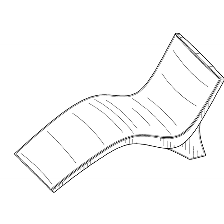
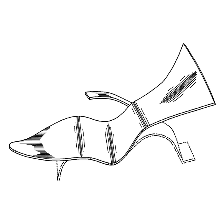
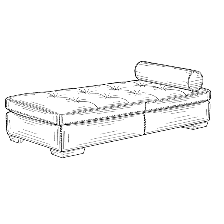
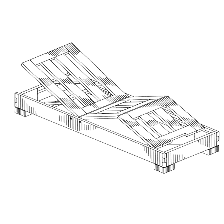
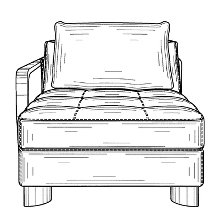
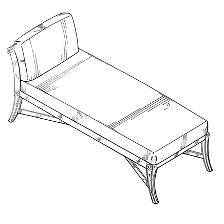

In [ ]:
import html
import ipyplot
query = "chaise lounge" #@param {type:"string"}
query_type = "combined search" #@param ["text search", "image search", "combined search"]
num_results = 7 #@param {type:"slider", min:1, max:14, step:1}
text_features_extracted = get_text_features(query)
if query_type == "text search":
  similarity = text_features_extracted.cpu().numpy() @ text_features.numpy().T
elif query_type == "image search":
  similarity = text_features_extracted.cpu().numpy() @ image_features.numpy().T
else:
  double_features_extracted = torch.hstack((text_features_extracted, text_features_extracted))
  similarity = double_features_extracted.cpu().numpy() @ combined_features.numpy().T
similarity = similarity[0]
scores, imgs, indices = get_top_N_semantic_similarity(similarity, N=num_results)
# print(query_type, "results", scores)
result_labels = []
for i in indices:
  file_name = image_files[i]
  parts = file_name.split("/")
  patent_name = parts[1][:-4]
  label = labels[patent_name]
  result_labels.append(label + " " + patent_name)
ipyplot.plot_images(imgs, img_width=224, labels=result_labels)